In [1]:
### TO RUN
import os

import matplotlib.pyplot as plt
import numpy as np
import pickle

"Machine learning tools"

from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS

Useful functions to select, read and play the dataset sounds are provided in the ``classification`` directory. <br>

As for the H1, you will have to fill some short pieces of code, as well as answer some questions. We already created cells for you to answer the questions to ensure you don't forget it ;). <br>
You will find the zones to be briefly filled  with a ``### TO COMPLETE`` in the cells below.

<font size=6 color=#009999> 3. Probability vector and memory  [~30min-1h] </font> <br>

In [2]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))

birds
chainsaw
fire
handsaw
helicopter


In [3]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

<font size=5 color=#009999> 3.1. Probability vector </font> <br>

A clear drawback of the models considered in ``hands_on_classif2_audio_student.ipynb`` is that they only output the most probable class, but do not provide any confidence estimate of this prediction. It is generally better to output a vector of probabilities for all the classes at each prediction, hence allowing the models to hesitate between different classes. 
Remember a vector of probability can be defined as 

\begin{equation*}
    \mathbb P \{ i \} \in [0,1], ~~\sum_i \mathbb P \{ i \} = 1. 
\end{equation*}

There are many ways to do so:

- **Adapt the models**, e.g. for the ``KNN`` classifier, give the probability of class ``i`` as the ratio between the number of neighbours with label ``i`` and the total number of considered neighbours ``K``.
- **Use other models**: a ``CNN`` classifier is suited for outputting probability values for each class.
- **Compare with old predictions**: the probability of class ``i`` may simply be given as the ratio of its appearances in the (arbitrarily chosen) ``N`` last predictions.

The last bullet implies the use of old predictions to compute a probability estimate. This leads to the notion of memory in the predictions, that we discuss in the second part of this notebook.

Let us start by creating a dataset ``myds`` and taking the model trained in ````hands_on_classif2_audio.ipynb````.

Don't forget to normalize your feature vectors as well as reduce their dimensionality if you trained your model with such data.

In [4]:
### TO COMPLETE - Uncomment the following line
model_dir = "data/models/"
filename = "model.pickle"
model = pickle.load(open(model_dir + filename, "rb"))
normalize = True
pca = None


"Creation of the dataset"
myds = Feature_vector_DS(
    dataset, Nft=512, nmel=20, duration=950, shift_pct=0.0, normalize=normalize, pca=pca
)

Open-Source code makes life easy! The ``KNeighborsClassifier`` from Sklearn already contains a ``predict_proba`` method. Start getting some intuition on this probability vector by playing with the chosen feature vector. <br>

Run the following code many times by changing  ``cls_index``. <br>

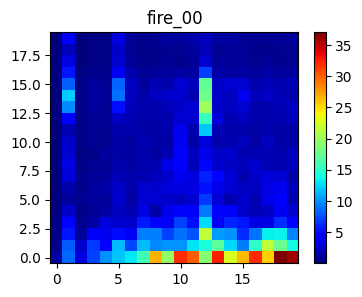

Class predicted : chainsaw


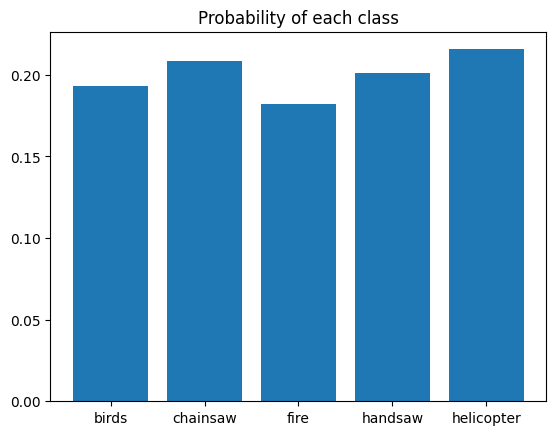

In [5]:
### TO RUN
cls_index = ["fire", 0]
myds.display(cls_index)
thisfv = myds.__getitem__(cls_index).reshape(-1)

# this artefact is necessary because the 'predict' function expects a matrix_like input.
mat = np.zeros((2, len(thisfv)))
mat[0] = thisfv

prediction = model.predict(mat)
print("Class predicted :", prediction[0])

proba = model.predict_proba(mat)
plt.figure()
plt.bar(classnames, proba[0])
plt.title("Probability of each class")
plt.show()
model_knn = model

**Question**:
When the classifier miss-predicts, how distributed is the probability vector? Is it good news? How can we exploit that probability distribution for the prediction?

In [6]:
### TO COMPLETE
# The classifier is not "confident" about its prediction so the probability vector is more or less constant. We could put threshold for each of
# the class, birds could have a higher threshold since it's not that important to predict birds whereas fire could have a lower threshold

<font size=6 color=#009999> 3.2. Memory </font> <br>

No matter if the predictions are one class only or probability vectors, as it is natural that consecutive feature vectors belong to the same class if the sound type changes slowlier than the duration of a feature vector, it can be helpful to link consecutive predictions and see how similar they are to either strengthen or decrease our confidence in the current guess. <br>

Here, we will compare the predictions made on consecutive feature vectors belonging to the same 5s-long sound. 
Run the following code with different ``class_id``'s and different ``num``.

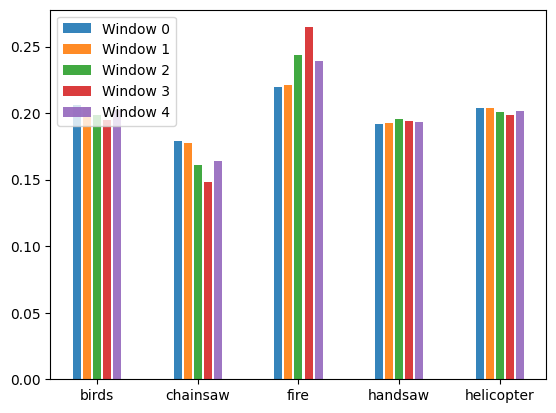

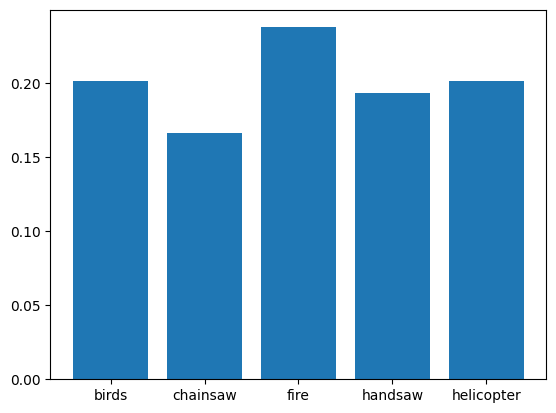

In [18]:
### TO RUN
num = 36  # 0 (default), 1, ..., 39

sound = dataset["birds", num]
audio = AudioUtil.open(sound)
audio = AudioUtil.resample(audio, 11025)
AudioUtil.play(audio)

"Bar charts for each window"
n_win = 5
probs = np.zeros((n_win, len(classnames)))
for window in range(n_win):
    sub_aud = (audio[0][window * 11025 :], audio[1])
    sub_aud = AudioUtil.pad_trunc(sub_aud, 950)
    sgram = AudioUtil.melspectrogram(sub_aud, Nmel=20)
    ncol = int(1000 * 11025 / (1e3 * 512))
    sgram = sgram[:, :ncol]
    fv = sgram.reshape(-1)

    ### TO COMPLETE - Eventually normalize and reduce feature vector dimensionality

    probs[window, :] = model_knn.predict_proba([fv])[0]

"Mean bar chart"
plt.figure()
for window in range(n_win):
    plt.bar(
        np.arange(len(classnames)) * 2 * n_win + window,
        probs[window, :],
        alpha=0.9,
        label=f"Window {window}",
    )
plt.legend()
plt.gca().set_xticks(np.arange(len(classnames)) * 2 * n_win + 2)
plt.gca().set_xticklabels(classnames)
plt.show()

plt.figure()
plt.bar(np.arange(len(classnames)), np.mean(probs, axis=0))
plt.gca().set_xticks(np.arange(len(classnames)))
plt.gca().set_xticklabels(classnames)
plt.show()

### Question:
Are the bar plots similar between the 5 windows of the same 5s-long sound? With the default sound, how often does the right class win?

In [ ]:
### TO COMPLETE
# The right class never wins with the default sound, the bar plots are usually really similar except for a few sounds (ex : 36)

If it is relevant to combine $N$ consecutive feature vectors, there are many ways to output a prediction from it:
- **Naive**: select the class that has the highest probability among all the considered feature vectors.
- **Majority voting**: simply select the class that appears most often as the maximum probability of a feature vector.
- **Average the feature representation**: compute the average of all feature vectors and classify from this average.
- **Maximum Likelihood**: take a probabilistic approach and consider selecting class $i$ as
    $$
        \text{argmax}_i~ \log \bigg(\prod_{n=0}^{N-1} P(y[n]=i) \bigg)
        = \text{argmax}_i~ \sum_{n=0}^{N-1} \log P(y[n]=i)
    $$
    with $y[n]$ the model prediction for the feature vector $n$.

It will be part of your work to decide how you want to exploit the time information in your predictions.

Now you have all the necessary material to test a new classification model and make some objective analysis of its performances. <br>
Follow the instructions on Moodle [written here](https://moodle.uclouvain.be/mod/assign/view.php?id=204607) to see what is expected in your ``fifth report (R5)``. <br>
A lot of other classification models are already implemented by SKlearn, check the [SKlearn API](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Don't hesitate to read some opinions and discussions on the forums or even articles to help you in the model choice. The most motivated of you are even allowed to give a try to more than one additional model, it is time smartly invested for the upcoming weeks of this project! Although we expect only one characterization in the ``R5``.

Also, don't hesitate to get information from the Internet to learn how people use to deal with sound classification. We mention for example this idea of transfer learning that could be interesting for you in the second semester: https://www.youtube.com/watch?v=uCGROOUO_wY&t=1s 